In [1]:
import pandas as pd
import numpy as np
import io
import requests
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Определение доходности облигаций по данным ММВБ

**Цель задания** - определить доходность низкорисковых облигаций ММВБ для клиента с консервативной инвестиционной стратегией.

Имеются данные по облигациям, которые торгуются на Московской бирже на текущую дату. Данные загружаются непосредственно с сайта биржи. 

Работа выполнена в учебных целях для демонстрации навыков анализа данных. 
В ходе работы имеются некоторые допущения:

- Анализ будет произведен лишь рублевых облигаций, российских эмитентов
- Период расчета доходности облигаций выбран не более 365 дней с текущей даты
- Предполагается, что досрочное гашение облигации с офертой исключено

План проекта:

1. [Загрузка и предобработка данных](#section1)
2. [Кластеризация по распределению купонной доходности](#section2)
3. [Расчет дохода последующих купонов по низкорисковым облигациям](#section3)
4. [Стратегия инвестирования.  Отбор и рейтингование облигаций.](#section4)

<a id = 'section1'></a>
### Загрузка и предобработка данных

In [2]:
bond_url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%20%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [3]:
s=requests.get(bond_url).content
df = pd.read_csv(io.StringIO(s.decode('windows-1251')), sep=';', header = 1, dtype={'INN':str})

In [4]:
df.columns

Index(['SECID', 'SHORTNAME', 'NAME', 'TYPENAME', 'ISIN', 'REGNUMBER',
       'LISTLEVEL', 'FACEVALUE', 'FACEUNIT', 'ISSUESIZE', 'IS_COLLATERAL',
       'IS_EXTERNAL', 'PRIMARY_BOARDID', 'PRIMARY_BOARD_TITLE', 'MATDATE',
       'IS_RII', 'ISSUEDATE', 'EVENINGSESSION', 'DURATION',
       'IS_QUALIFIED_INVESTORS', 'HIGH_RISK', 'COUPONFREQUENCY', 'YIELDATWAP',
       'COUPONDATE', 'COUPONPERCENT', 'COUPONVALUE', 'COUPONDAYSPASSED',
       'COUPONDAYSREMAIN', 'COUPONLENGTH', 'ISSUEDATE.1', 'INITIALFACEVALUE',
       'SECSUBTYPE', 'STARTDATEMOEX', 'DAYSTOREDEMPTION', 'OFFERDATE',
       'EMITENTNAME', 'INN', 'LOTSIZE', 'PRICE', 'PRICE_RUB', 'RTL1', 'RTH1',
       'RTL2', 'RTH2', 'RTL3', 'RTH3', 'DISCOUNT1', 'LIMIT1', 'DISCOUNT2',
       'LIMIT2', 'DISCOUNT3', 'DISCOUNTL0', 'DISCOUNTH0'],
      dtype='object')

Для определения доходности облигаций в работе будут использоваться следующие поля:

 - 'SECID' - Код ценной бумаги,
 - 'SHORTNAME' - Краткое наименование,
 - 'NAME' - Полное наименование,
 - 'TYPENAME' - Типы облигаций,
 - 'LISTLEVEL' - Уровень листинга,
 - 'FACEVALUE' - Номинальная стоимость,
 - 'FACEUNIT' - Валюта,
 - 'ISSUESIZE' - Объем выпуска,
 - 'DURATION' - Дюрация,
 - 'IS_QUALIFIED_INVESTORS' - Признак продукта для квалифицированных инвесторов,
 - 'HIGH_RISK' - Признак уровня риска,
 - 'COUPONFREQUENCY' – Число купонов в год,
 - 'COUPONDATE' - Дата выплаты купона,
 - 'COUPONPERCENT' - Ставка купона, %,
 - 'COUPONVALUE' - Сумма купона, в валюте номинала,
 - 'COUPONDAYSPASSED' - Кол-во дней, прошедших с дня выплаты последнего купона,
 - 'COUPONDAYSREMAIN' - Оставшиеся дни до выплаты купона,
 - 'COUPONLENGTH' - Длинна купона в днях,
 - 'DAYSTOREDEMPTION' - Кол-во дней до гашения,
 - 'OFFERDATE' - Дата оферты,
 - 'EMITENTNAME' – наименование эмитента,
 - 'INN' – ИНН эмитента,
 - 'PRICE' – Текущий % от FACEVALUE, 
 - 'PRICE_RUB' - Котировка

Остальные столбцы для решение нашей задачи менее информативны.

In [5]:
df = df[['SECID', 'SHORTNAME', 'NAME', 'TYPENAME', 'LISTLEVEL', 'FACEVALUE', 'FACEUNIT', 'ISSUESIZE','DURATION',
         'IS_QUALIFIED_INVESTORS', 'HIGH_RISK', 'COUPONFREQUENCY', 'COUPONDATE', 'COUPONPERCENT',
         'COUPONVALUE', 'COUPONDAYSPASSED', 'COUPONDAYSREMAIN','COUPONLENGTH', 'DAYSTOREDEMPTION',
         'OFFERDATE', 'EMITENTNAME', 'INN', 'PRICE', 'PRICE_RUB']]

Нас интересуют лишь рублевые облигации, отфильтруем данные в соответсвии с поставленной задачей. Затем оценим качество наших данных.

In [6]:
df = df.query('FACEUNIT == "RUB" and TYPENAME != "Корпоративные еврооблигации"')

In [7]:
len(df)

2244

In [8]:
df.isna().mean()

SECID                     0.000000
SHORTNAME                 0.000000
NAME                      0.000000
TYPENAME                  0.000000
LISTLEVEL                 0.062834
FACEVALUE                 0.000000
FACEUNIT                  0.000000
ISSUESIZE                 0.007576
DURATION                  0.274064
IS_QUALIFIED_INVESTORS    0.000000
HIGH_RISK                 0.000000
COUPONFREQUENCY           0.156417
COUPONDATE                0.000891
COUPONPERCENT             0.015152
COUPONVALUE               0.013815
COUPONDAYSPASSED          0.000891
COUPONDAYSREMAIN          0.000891
COUPONLENGTH              0.000891
DAYSTOREDEMPTION          0.012478
OFFERDATE                 0.774510
EMITENTNAME               0.062834
INN                       0.062834
PRICE                     0.067736
PRICE_RUB                 0.067736
dtype: float64

Имеем достаточное кол-во пропусков в данных, так как данные затрагивают денежную составляющую, то нет смысла что-то выдумывать и искать какие-либо замены для пропусков. Предлагаю поле `OFFERDATE` заменить на булевую переменную есть или нет оферта по бумаге, а сам столбец удалить. Из-за того что в `OFFERDATE` почти все значения пропущены, а 

*Оферта — предложение о заключении сделки, в котором изложены существенные условия договора, адресованное ограниченному или неограниченному кругу лиц. Если получатель принимает оферту, это означает заключение между сторонами предложенного договора на оговоренных в оферте условиях.*,

то логичнее заменить ее на булевую переменную, а не терять значительный объем данных. Пропуски в оставшихся полях просто удалим. Для учебных целей данных достаточно для анализа.

In [9]:
df['OFFER'] = np.where(df['OFFERDATE'].isnull(), 0, 1)

In [10]:
df = df.drop('OFFERDATE', axis = 1)

In [11]:
df.dropna(inplace = True)

In [12]:
df.isna().mean()

SECID                     0.0
SHORTNAME                 0.0
NAME                      0.0
TYPENAME                  0.0
LISTLEVEL                 0.0
FACEVALUE                 0.0
FACEUNIT                  0.0
ISSUESIZE                 0.0
DURATION                  0.0
IS_QUALIFIED_INVESTORS    0.0
HIGH_RISK                 0.0
COUPONFREQUENCY           0.0
COUPONDATE                0.0
COUPONPERCENT             0.0
COUPONVALUE               0.0
COUPONDAYSPASSED          0.0
COUPONDAYSREMAIN          0.0
COUPONLENGTH              0.0
DAYSTOREDEMPTION          0.0
EMITENTNAME               0.0
INN                       0.0
PRICE                     0.0
PRICE_RUB                 0.0
OFFER                     0.0
dtype: float64

In [13]:
len(df)

1352

Оценим типы данных и приведем их в соответсвие

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1352 entries, 13 to 2335
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   1352 non-null   object 
 1   SHORTNAME               1352 non-null   object 
 2   NAME                    1352 non-null   object 
 3   TYPENAME                1352 non-null   object 
 4   LISTLEVEL               1352 non-null   float64
 5   FACEVALUE               1352 non-null   object 
 6   FACEUNIT                1352 non-null   object 
 7   ISSUESIZE               1352 non-null   float64
 8   DURATION                1352 non-null   float64
 9   IS_QUALIFIED_INVESTORS  1352 non-null   int64  
 10  HIGH_RISK               1352 non-null   int64  
 11  COUPONFREQUENCY         1352 non-null   float64
 12  COUPONDATE              1352 non-null   object 
 13  COUPONPERCENT           1352 non-null   object 
 14  COUPONVALUE             1352 non-null  

In [15]:
wrong_comma = ['FACEVALUE', 'COUPONPERCENT', 'COUPONVALUE', 'PRICE', 'PRICE_RUB']

for element in wrong_comma:
    df[element] = df[element].str.replace(',' , '.')

In [16]:
df[['FACEVALUE',
    'DURATION',
    'COUPONPERCENT',
    'COUPONVALUE',
    'PRICE',
    'PRICE_RUB']] = df[['FACEVALUE',
                        'DURATION',
                        'COUPONPERCENT',
                        'COUPONVALUE',
                        'PRICE',
                        'PRICE_RUB']].astype('float64')

In [17]:
df['COUPONDATE'] = df['COUPONDATE'].astype('datetime64')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1352 entries, 13 to 2335
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SECID                   1352 non-null   object        
 1   SHORTNAME               1352 non-null   object        
 2   NAME                    1352 non-null   object        
 3   TYPENAME                1352 non-null   object        
 4   LISTLEVEL               1352 non-null   float64       
 5   FACEVALUE               1352 non-null   float64       
 6   FACEUNIT                1352 non-null   object        
 7   ISSUESIZE               1352 non-null   float64       
 8   DURATION                1352 non-null   float64       
 9   IS_QUALIFIED_INVESTORS  1352 non-null   int64         
 10  HIGH_RISK               1352 non-null   int64         
 11  COUPONFREQUENCY         1352 non-null   float64       
 12  COUPONDATE              1352 non-null   datetim

In [19]:
df.sample(5)

,SECID,SHORTNAME,NAME,TYPENAME,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,DURATION,IS_QUALIFIED_INVESTORS,...,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,DAYSTOREDEMPTION,EMITENTNAME,INN,PRICE,PRICE_RUB,OFFER
1250,RU000A101F52,ВТБ Б-1-51,Банк ВТБ (ПАО) Б-1-51,Биржевые облигации,3.0,1000.00,RUB,179874.0,474.0,0,...,0.05,71.0,111.0,182.0,475.0,Банк ВТБ (публичное акционерное общество),7702070139,89.18,891.82,0
1594,RU000A102580,ГрупПроБ01,Группа Продовольствие БО-01,Биржевые облигации,3.0,1000.00,RUB,70000.0,329.0,0,...,10.68,10.0,20.0,30.0,350.0,"Общество с ограниченной ответственностью ""Груп...",0411137185,100.67,1010.62,0
411,RU000A0JXLR8,ОткрФКБОП3,ПАО ОТКРЫТИЕ ФК Банк БО-П03,Биржевые облигации,1.0,1000.00,RUB,10000000.0,512.0,0,...,32.26,22.0,162.0,184.0,530.0,"Публичное акционерное общество Банк ""Финансова...",7706092528,96.92,973.23,0
1286,RU000A101HU5,Брус 1P01,Брусника 001P-01,Биржевые облигации,3.0,1000.00,RUB,4000000.0,341.0,0,...,27.42,48.0,43.0,91.0,498.0,"Общество с ограниченной ответственностью ""Брус...",6685151087,100.33,1018.07,0
199,RU000A0JV508,ИА ТФБ1 А,ЗАО ИА ТФБ1 кл.А,Корпоративные облигации,3.0,26.23,RUB,2382831.0,3383.0,0,...,0.72,31.0,60.0,91.0,9281.0,"Закрытое акционерное общество ""Ипотечный агент...",7704860051,109.98,29.10,0


<a id = 'section2'></a>
### Кластеризация по распределению купонной доходности


В своей работе я выбрал 3 основных показателя для определения кластеров. Так как необходимо оценить распределение купонного дохода, то смотрел исключительно на возможность преумножить свой доход. В расчет разделения надежность эмитента не принималась во внимание.

 - **'COUPONPERCENT'** - Ставка купона, %,
 - **'COUPONFREQUENCY'** - Число купонов в год,
 - **'DURATION'** - Дюрация

В первую очередь мы смотрим на доходность о чем говорит ставка купона. Частота выплата купонов нам так же интересна, так как это подсказывает нам о частоте реинвестерования собственных средств. Сложнее всего было определиться с последним признаком. Пришел ко мнению что Дюрация - агрегированный показатель, который мне подходит.
Дюрация показывает среднее время, за которое мы полностью вернем свои вложения в облигации. Таким образом очевидно, что при прочих равных условиях нужно выбирать облигации с меньшей дюрацией, или сроком возврата средств. Дюрация откликация на изменение коньюктуры рынка и позволяет объективно оценить срок возврата инвестиций.

Посмотрим для начала как распределена ставки купона, так как это основной показатель доходности

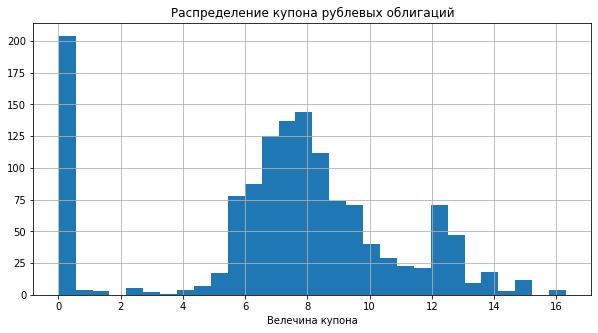

In [20]:
plt.figure(figsize = (10,5))
df['COUPONPERCENT'].hist(bins = 30)
plt.xlabel('Велечина купона')
plt.title('Распределение купона рублевых облигаций')
plt.show()

Определенно имеется выброс возле 0. Попробуем разобраться что это такое.

In [21]:
df.query('COUPONPERCENT < 1')['EMITENTNAME'].value_counts()

Банк ВТБ (публичное акционерное общество)                                                      127
Публичное акционерное общество "Сбербанк России"                                                34
Акционерное общество "Открытие Холдинг"                                                         11
Публичное акционерное общество Банк "Финансовая Корпорация Открытие"                             9
"МОСКОВСКИЙ КРЕДИТНЫЙ БАНК" (публичное акционерное общество)                                     6
Общество с ограниченной ответственностью "ИКС 5 ФИНАНС"                                          2
Публичное акционерное общество "Федеральная гидрогенерирующая компания - РусГидро"               2
"Газпромбанк" (Акционерное общество)                                                             2
Общество с ограниченной ответственностью "Финанс-менеджмент"                                     1
Общество с ограниченной ответственностью "ДелоПортс"                                             1
Акционерно

После блужданий в интернете, я понял что это в итоге сложно структурируемые облигации

Структурные облигации — это облигации, выплаты по которым (доход, выплаты при погашении, а также рыночная цена) зависят от того, наступило или не наступило одно либо сразу несколько событий. При этом размер выплат при погашении такой облигации может быть меньше номинальной стоимости, как и цена на вторичном рынке.

Другими словами, в структурных облигациях  заложена торговая стратегия, и если ее условия выполняются, то инвестор получает прибыль, а если нет, то он может лишиться не только дохода, но и вложенных денег. Событиями, которые влияют на выплаты, могут быть:

* изменение цен на товары и ценные бумаги   либо индексов, курсов валют и другого. Когда речь идет об изменении цен на инструмент на бирже, то этот инструмент называется базовым активом;

* изменение процентных ставок и уровня инфляции;

* исполнение или, наоборот, ненадлежащее исполнение государствами, муниципальными образованиями или компаниями своих обязанностей. В последнем случае облигации служат страховкой;

* другие обстоятельства, которые определяются законом и Банком России.

Выпускать подобные бумаги могут только банки, инвестиционные компании, брокеры и дилеры. Любые облигации бывают купонные и бескупонные (дисконтные). По первым эмитент  периодически выплачивает купоны. По дисконтным облигациям инвестор не будет получать купонный доход. Такие бумаги продаются ниже номинальной стоимости. Чем ближе дата их погашения, тем выше будет их цена, а в конце срока достигнет номинальной, поэтому инвестор может заработать на разнице цены покупки и погашения.

По структурным облигациям могут выплачивать базовый купонный доход, который обычно составляет **0,01%**, но его могут и не платить. Основной доход по таким бумагам — дополнительный, который как раз и зависит от динамики базового актива и определенного события. Кроме того, на него влияет коэффициент участия, который показывает, какой процент от роста базового актива получит инвестор. Он устанавливается в день размещения облигаций на бирже.

Определенно это отдельный кластер, сначала хотел его разметить, но в итоге K-mean сам его выделил

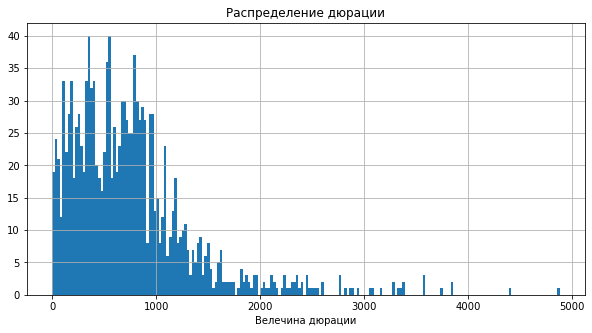

In [22]:
plt.figure(figsize = (10,5))
df['DURATION'].hist(bins = 200)
plt.xlabel('Велечина дюрации')
plt.title('Распределение дюрации')
plt.show()

In [23]:
df['DURATION_LVL'] = pd.qcut(df.DURATION, q=4, labels=False )

Данные шумноваты, для удобства разметил дюрацию на уровни:
- 0 - низкий уровень ,
- 1 - средний уровень,
- 2 - умеренный уровень, 
- 3 - высокий уровень 

In [24]:
df.columns

Index(['SECID', 'SHORTNAME', 'NAME', 'TYPENAME', 'LISTLEVEL', 'FACEVALUE',
       'FACEUNIT', 'ISSUESIZE', 'DURATION', 'IS_QUALIFIED_INVESTORS',
       'HIGH_RISK', 'COUPONFREQUENCY', 'COUPONDATE', 'COUPONPERCENT',
       'COUPONVALUE', 'COUPONDAYSPASSED', 'COUPONDAYSREMAIN', 'COUPONLENGTH',
       'DAYSTOREDEMPTION', 'EMITENTNAME', 'INN', 'PRICE', 'PRICE_RUB', 'OFFER',
       'DURATION_LVL'],
      dtype='object')

In [25]:
df_cluster = df[['COUPONPERCENT', 'COUPONFREQUENCY', 'DURATION_LVL']]

Масштабируем данные и с помощью метода локтя найдем оптимальное число кластеров

In [26]:
df_cluster_scaler = StandardScaler()
df_cluster = df_cluster_scaler.fit_transform(df_cluster)

In [27]:
distortion = []
K = range(1, 8)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_cluster)
    distortion.append(model.inertia_)

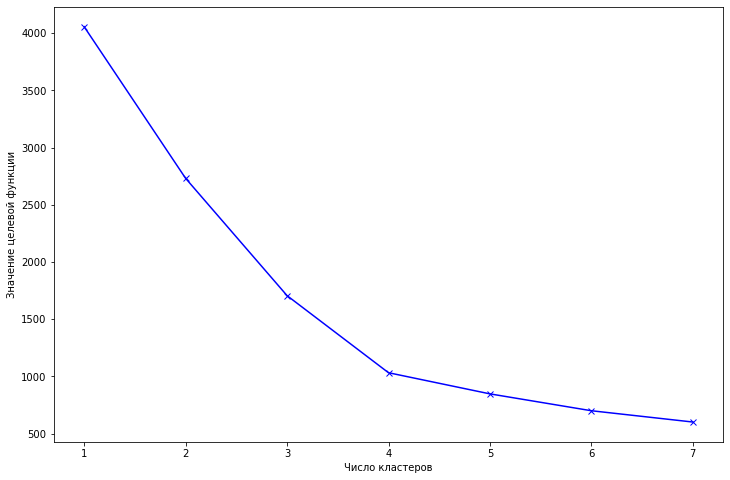

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

In [29]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(df_cluster)

KMeans(n_clusters=4, random_state=42)

In [30]:
pred = model.predict(df_cluster)
pred

array([2, 1, 2, ..., 3, 3, 3], dtype=int32)

In [31]:
df['Cluster_id'] = pred

In [32]:
df['Cluster_id'].value_counts(normalize = True)

2    0.392012
1    0.372781
3    0.160503
0    0.074704
Name: Cluster_id, dtype: float64

In [33]:
df[['COUPONPERCENT', 'COUPONFREQUENCY', 'DURATION_LVL',
    'Cluster_id']].query('Cluster_id == 0')

,COUPONPERCENT,COUPONFREQUENCY,DURATION_LVL,Cluster_id
526,14.00,12.0,0,0
646,14.50,12.0,0,0
668,13.00,12.0,1,0
677,12.25,12.0,0,0
760,12.50,12.0,0,0
...,...,...,...,...
2259,13.00,12.0,3,0
2262,12.25,12.0,3,0
2267,12.60,12.0,3,0
2269,13.00,12.0,2,0


In [34]:
cluster_0 = df.query('Cluster_id == 0')
cluster_1 = df.query('Cluster_id == 1')
cluster_2 = df.query('Cluster_id == 2')
cluster_3 = df.query('Cluster_id == 3')

In [35]:
df_cluster = df[['COUPONPERCENT', 'COUPONFREQUENCY', 'DURATION_LVL']]

In [36]:
df_cluster_scaler = StandardScaler()
df_cluster = df_cluster_scaler.fit_transform(df_cluster)

In [37]:
pca = PCA(2)

In [38]:
df_pca = pca.fit_transform(df_cluster)

In [39]:
df_graphic = pd.DataFrame(df_pca, columns = ['x','y'])

In [40]:
df_graphic['Cluster_id'] = pred

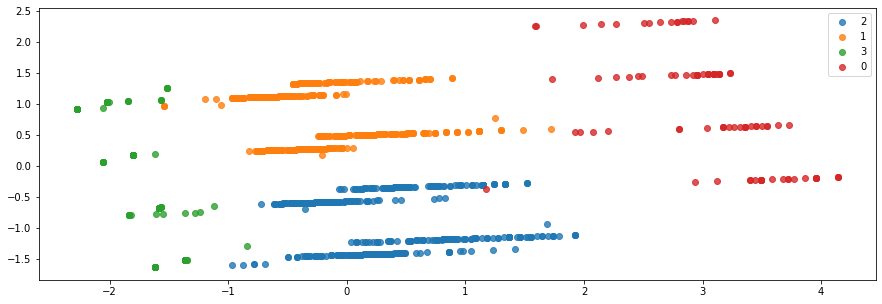

In [41]:
plt.figure(figsize = (15,5))
for i in df_graphic.Cluster_id.unique():
    plt.scatter(df_graphic[df_graphic['Cluster_id'] == i]['x'],
                df_graphic[df_graphic['Cluster_id'] == i]['y'], label = i, alpha = 0.8)
plt.legend()
plt.show()

In [42]:
cluster_0['COUPONFREQUENCY'].value_counts(normalize = True)

12.0    1.0
Name: COUPONFREQUENCY, dtype: float64

In [43]:
cluster_0['DURATION_LVL'].value_counts(normalize = True)

2    0.326733
0    0.257426
1    0.247525
3    0.168317
Name: DURATION_LVL, dtype: float64

In [44]:
cluster_0['COUPONPERCENT'].mean()

11.867564356435642

*  `Красный кластер` - включил в себя облигации с ежемесячной выплатой купона со средним занчением около 12% годовых. Уровни дюрации распределились более менее равномерно, есть небольшой перекос в сторону умеренной дюрации

In [45]:
cluster_1['COUPONFREQUENCY'].value_counts(normalize = True)

2.0    0.517857
4.0    0.470238
1.0    0.009921
6.0    0.001984
Name: COUPONFREQUENCY, dtype: float64

In [46]:
cluster_1['DURATION_LVL'].value_counts(normalize = True)

2    0.515873
3    0.484127
Name: DURATION_LVL, dtype: float64

In [77]:
cluster_1['COUPONPERCENT'].mean()

8.017799603174598

*  `Оранжевый кластер` - включил в себя облигации с частотой выплаты купона 2 - 4 раза в год со средним значением купона 8%. Однако следует заметить, что уровень дюрации по данным облигациям лишь умеренный или высокий.

In [48]:
cluster_2['COUPONFREQUENCY'].value_counts(normalize = True)

2.0    0.567925
4.0    0.418868
1.0    0.011321
6.0    0.001887
Name: COUPONFREQUENCY, dtype: float64

In [49]:
cluster_2['DURATION_LVL'].value_counts(normalize = True)

0    0.515094
1    0.484906
Name: DURATION_LVL, dtype: float64

In [50]:
cluster_2['COUPONPERCENT'].mean()

8.507466037735847

*  `Синий кластер` - включил в себя облигации с частотой выплаты купона 2 - 4 раза в год со средним значением купона 8,5%. Уровень дюрации по данным облигациям низкий или средний.

In [51]:
cluster_3['COUPONFREQUENCY'].value_counts(normalize = True)

2.0    0.746544
1.0    0.225806
4.0    0.027650
Name: COUPONFREQUENCY, dtype: float64

In [52]:
cluster_3['DURATION_LVL'].value_counts(normalize = True)

3    0.354839
1    0.258065
2    0.202765
0    0.184332
Name: DURATION_LVL, dtype: float64

In [76]:
cluster_3['COUPONPERCENT'].median()

0.01

*  `Зеленый кластер` - сложноструктурированные облигации, выплаты по которым зависят от того, наступило или не наступило одно либо сразу несколько событий. Высокорисковый инструмент. Уровни дюрации распределились более менее равномерно.

#### Резюмируя
Было выделено 4 кластера

*  `Красный кластер (0)` - включил в себя облигации с ежемесячной выплатой купона со средним значением около 12% годовых. Уровни дюрации распределились более менее равномерно, есть небольшой перекос в сторону умеренной дюрации

*  `Зеленый кластер (3)` - сложноструктурированные облигации, выплаты по которым зависят от того, наступило или не наступило одно либо сразу несколько событий. Высокорисковый инструмент. Уровни дюрации распределились более менее равномерно.

*  `Оранжевый кластер (1)` - включил в себя облигации с частотой выплаты купона 2 - 4 раза в год со средним значением купона 8%. Однако следует заметить, что уровень дюрации по данным облигациям умеренный или высокий.

*  `Синий кластер (2)` - включил в себя облигации с частотой выплаты купона 2 - 4 раза в год со средним значением купона 8,5%. Уровень дюрации по данным облигациям низкий или средний.


<a id = 'section3'></a>
### Расчет дохода последующих купонов по низкорисковым облигациям

In [54]:
df_calculate = df.copy().query('COUPONDAYSPASSED/COUPONLENGTH <= 0.2')

In [55]:
df_calculate = df_calculate.query('HIGH_RISK == 0')

In [56]:
df_calculate = df_calculate.query('DAYSTOREDEMPTION > 365')

In [57]:
df_calculate.columns

Index(['SECID', 'SHORTNAME', 'NAME', 'TYPENAME', 'LISTLEVEL', 'FACEVALUE',
       'FACEUNIT', 'ISSUESIZE', 'DURATION', 'IS_QUALIFIED_INVESTORS',
       'HIGH_RISK', 'COUPONFREQUENCY', 'COUPONDATE', 'COUPONPERCENT',
       'COUPONVALUE', 'COUPONDAYSPASSED', 'COUPONDAYSREMAIN', 'COUPONLENGTH',
       'DAYSTOREDEMPTION', 'EMITENTNAME', 'INN', 'PRICE', 'PRICE_RUB', 'OFFER',
       'DURATION_LVL', 'Cluster_id'],
      dtype='object')

In [58]:
df_calculate['NKD'] = df_calculate[
    'PRICE_RUB'] / 100 * df_calculate['COUPONPERCENT'] / 365 * df_calculate['COUPONDAYSPASSED']

In [59]:
df_calculate['EXPECTED_PROFIT'] = (
    df_calculate['FACEVALUE'] - df_calculate['PRICE_RUB'] - df_calculate['NKD'] + df_calculate[
        'FACEVALUE'] * df_calculate['COUPONPERCENT']/100)*100 / (df_calculate['PRICE_RUB'] + df_calculate['NKD'])

In [60]:
df_calculate['PROFIT'] = (
    df_calculate['FACEVALUE'] - df_calculate['PRICE_RUB'] - df_calculate['NKD'] + 0.87 * df_calculate[
        'FACEVALUE'] * df_calculate['COUPONPERCENT']/100)*100 / (df_calculate['PRICE_RUB'] + df_calculate['NKD'])

In [61]:
df_profit = df_calculate[['SECID', 'FACEVALUE',
              'COUPONPERCENT', 'PRICE_RUB',
              'NKD', 'PROFIT', 'EXPECTED_PROFIT', 'EMITENTNAME', 'COUPONFREQUENCY', 'DURATION_LVL', 'Cluster_id']]

In [62]:
df_profit.groupby('Cluster_id')['PROFIT'].mean()

Cluster_id
0    8.840739
1    7.919551
2    7.042188
3    8.011297
Name: PROFIT, dtype: float64

In [63]:
df_profit.head()

,SECID,FACEVALUE,COUPONPERCENT,PRICE_RUB,NKD,PROFIT,EXPECTED_PROFIT,EMITENTNAME,COUPONFREQUENCY,DURATION_LVL,Cluster_id
21,RU000A0JRDY3,500.0,7.71,501.27,1.270616,6.168234,7.165467,"Акционерное общество ""ДОМ.РФ""",4.0,1,2
26,RU000A0JRU20,851.0,9.68,851.08,4.288511,7.867873,9.119846,"Общество с ограниченной ответственностью ""Севе...",2.0,3,1
27,RU000A0JRU46,851.0,9.68,851.26,4.289418,7.845064,9.096772,"Общество с ограниченной ответственностью ""Севе...",2.0,3,1
49,RU000A0JS6M0,1000.0,6.75,968.09,1.074182,9.241037,10.146456,Публичное акционерное общество РОСБАНК,2.0,2,1
59,RU000A0JT403,1000.0,7.67,983.27,5.372156,7.898393,8.906948,"государственная корпорация развития ""ВЭБ.РФ""",2.0,3,1


<a id = 'section4'></a>
### Стратегия инвестирования.  Отбор и рейтингование облигаций.

В работе использована консервативная стратегия для выбора облигаций. К выбору предлагаются лишь низкорисковые облигации. Прогноз строился с горизонтом событий 365 дней. Решение о продаже бумаг будет приниматься в конце года.

Задача заключается в том, чтобы выбрать бумаги с наиболее привлекательным доходом. За привлекательных доход будем брать купонную ставку, которая выше ключевой на текущий момент. Так же для консервативной стратегии выберем лишь облигации с низкой и средней Дюрацией.

Ранее мною были предложены 4 кластера для разделения облигаций по распределению купонного дохода.

*  `Красный кластер (0)` - включил в себя облигации с ежемесячной выплатой купона со средним значением около 12% годовых. Уровни дюрации распределились более менее равномерно, есть небольшой перекос в сторону умеренной дюрации


*  `Зеленый кластер (3)` - сложноструктурированные облигации, выплаты по которым зависят от того, наступило или не наступило одно либо сразу несколько событий. Высокорисковый инструмент. Уровни дюрации распределились более менее равномерно.


*  `Оранжевый кластер (1)` - включил в себя облигации с частотой выплаты купона 2 - 4 раза в год со средним значением купона 8%. Однако следует заметить, что уровень дюрации по данным облигациям умеренный или высокий.


*  `Синий кластер (0)` - включил в себя облигации с частотой выплаты купона 2 - 4 раза в год со средним значением купона 8,5%. Уровень дюрации по данным облигациям низкий или средний.

22.10.2021 ключевая ставка была поднята на 0,75 пунктов стала составлять 7,5 %

Призведем отбор облигаций по следющим критериям:

- реальный доход должен быть выше ключевой ставки, выше 7,5 %
- уровень дюрации должен быть не выше среднего
- в формировании портфеля не будут участвовать сложноструктурированные облигации

In [64]:
df_profit = df_profit.query('PROFIT > 7.5')
df_profit.sample(5)

,SECID,FACEVALUE,COUPONPERCENT,PRICE_RUB,NKD,PROFIT,EXPECTED_PROFIT,EMITENTNAME,COUPONFREQUENCY,DURATION_LVL,Cluster_id
1739,RU000A102EY2,1000.0,0.01,922.30,0.007075,8.433192,8.434601,Банк ВТБ (публичное акционерное общество),2.0,2,3
1154,RU000A1014V7,9000.0,13.25,9067.07,9.874412,10.582092,12.289990,"Общество с ограниченной ответственностью ""Трей...",12.0,1,0
423,RU000A0JXP45,1000.0,6.10,956.97,1.439388,9.876845,10.704258,"""Газпромбанк"" (Акционерное общество)",2.0,2,1
64,RU000A0JT7T2,1000.0,7.40,970.54,2.754738,9.358446,10.346841,"Публичное акционерное общество ""Федеральная се...",2.0,2,1
1099,RU000A100ZF0,1000.0,7.00,979.89,0.000000,8.267254,9.195930,"Открытое акционерное общество ""Межрегиональная...",2.0,1,2


In [65]:
hard_structured = df_profit[df_profit['COUPONPERCENT'] == 0.01]['Cluster_id'].values[0]

Убраны сложноструктурируемые облигации из выборки, по которой планируется отбор. Так как для того чтобы получить нормальный доход необходимо чтобы произошли событие которые мы вряд ли сможем спрогнозировать

In [66]:
df_profit = df_profit.query('Cluster_id != @hard_structured')
df_profit.sample(5)

,SECID,FACEVALUE,COUPONPERCENT,PRICE_RUB,NKD,PROFIT,EXPECTED_PROFIT,EMITENTNAME,COUPONFREQUENCY,DURATION_LVL,Cluster_id
2038,RU000A1034X1,1000.0,11.00,961.91,1.159563,13.771636,15.256472,"Общество с ограниченной ответственностью ""Лизи...",12.0,3,0
1653,RU000A1029A9,1000.0,5.90,958.09,1.084085,9.607840,10.407487,Федеральное государственное унитарное предприя...,2.0,2,1
1978,RU000A103117,1000.0,7.30,976.70,1.172040,8.757583,9.728058,"Общество с ограниченной ответственностью ""МВ Ф...",2.0,1,2
1499,RU000A101XN7,1000.0,6.35,964.19,1.174199,9.310559,10.165677,"Публичное акционерное общество ""Акционерная фи...",4.0,1,2
1052,RU000A100VQ6,1000.0,7.20,979.52,5.603391,7.868721,8.818856,"Публичное акционерное общество ""Горно-металлур...",2.0,3,1


In [67]:
bond_portfolio = df_profit.query('DURATION_LVL == 0 or DURATION_LVL == 1').sort_values('PROFIT', ascending = False)

In [68]:
bonds_number = bond_portfolio.shape[0]

In [69]:
bond_portfolio['Cluster_id'].value_counts(normalize=True)

2    0.896552
0    0.103448
Name: Cluster_id, dtype: float64

In [70]:
mean_profit = round(bond_portfolio['PROFIT'].mean(), 2)

### Вывод

В работе рассчитана доходность облигаций для клиента с консервативной инвестиционной стратегией.

Под консервативной инвестиционной стратегией подразумевается:

- К выбору предлагаются лишь низкорисковые рублевые облигации российских эмитентов
- Горизонт расчета доходности облигаций 365 дней

Произведено ранжирование имеющихся облигацией в соответсвии со следующими принципами:

- реальный доход должен быть выше ключевой ставки, выше 7,5 %
- уровень дюрации должен быть не выше среднего
- в рейтинговании не будут участвовать сложноструктурированные облигации

In [78]:
print(f'В финальный рейтинг на текущую дату в соответствии с условиями, описанными выше, вошло {bonds_number} бумаг(и),\
принадлежащих(ие) красному и синему кластеру. Средняя доходность бумаг предложенного рейтингования \
составила {mean_profit} %.')

В финальный рейтинг на текущую дату в соответствии с условиями, описанными выше, вошло 29 бумаг(и),принадлежащих(ие) красному и синему кластеру. Средняя доходность бумаг предложенного рейтингования составила 8.43 %.


Для выбранной инвестиционной стратегии подходя следующие бумаги:

In [72]:
tabl_1 = bond_portfolio.sort_values(by = 'PROFIT', ascending= False)
tabl_1.head(5)

,SECID,FACEVALUE,COUPONPERCENT,PRICE_RUB,NKD,PROFIT,EXPECTED_PROFIT,EMITENTNAME,COUPONFREQUENCY,DURATION_LVL,Cluster_id
1154,RU000A1014V7,9000.0,13.25,9067.07,9.874412,10.582092,12.289990,"Общество с ограниченной ответственностью ""Трей...",12.0,1,0
1484,RU000A101WQ2,1000.0,5.25,947.72,0.545264,10.272414,10.992150,"Акционерное общество ""Российский Сельскохозяйс...",12.0,1,0
1497,RU000A101XH9,1000.0,5.55,954.32,1.015763,9.729484,10.484716,"Публичное акционерное общество ""Россети Москов...",4.0,1,2
2274,RU000A103WX4,1000.0,12.00,1007.79,0.662656,9.514313,11.061238,"Акционерное общество ""Коммерческая недвижимост...",4.0,1,2
1499,RU000A101XN7,1000.0,6.35,964.19,1.174199,9.310559,10.165677,"Публичное акционерное общество ""Акционерная фи...",4.0,1,2


In [73]:
tabl_2 = bond_portfolio.sort_values(by = ['COUPONFREQUENCY', 'PROFIT'], ascending= [False, False])
tabl_2

,SECID,FACEVALUE,COUPONPERCENT,PRICE_RUB,NKD,PROFIT,EXPECTED_PROFIT,EMITENTNAME,COUPONFREQUENCY,DURATION_LVL,Cluster_id
1154,RU000A1014V7,9000.0,13.25,9067.07,9.874412,10.582092,12.289990,"Общество с ограниченной ответственностью ""Трей...",12.0,1,0
1484,RU000A101WQ2,1000.0,5.25,947.72,0.545264,10.272414,10.992150,"Акционерное общество ""Российский Сельскохозяйс...",12.0,1,0
1568,RU000A1022E6,1000.0,10.00,1002.02,1.647156,8.302837,9.598087,"Общество с ограниченной ответственностью ""Лизи...",12.0,1,0
1497,RU000A101XH9,1000.0,5.55,954.32,1.015763,9.729484,10.484716,"Публичное акционерное общество ""Россети Москов...",4.0,1,2
2274,RU000A103WX4,1000.0,12.00,1007.79,0.662656,9.514313,11.061238,"Акционерное общество ""Коммерческая недвижимост...",4.0,1,2
1499,RU000A101XN7,1000.0,6.35,964.19,1.174199,9.310559,10.165677,"Публичное акционерное общество ""Акционерная фи...",4.0,1,2
806,RU000A1001L5,1000.0,10.25,998.55,1.962903,8.861665,10.193481,"Акционерное общество ""Южноуральский арматурно-...",4.0,0,2
263,RU000A0JVWB3,1000.0,7.00,977.55,0.937377,8.422451,9.352458,"Акционерное общество ""Российский Сельскохозяйс...",4.0,1,2
1329,RU000A101MB5,1000.0,6.20,974.37,0.000000,8.166302,8.993503,"Публичное акционерное общество ""Совкомбанк""",4.0,1,2
1496,RU000A101XE6,1000.0,6.60,977.23,1.413637,8.049545,8.926269,"Общество с ограниченной ответственностью ""Совк...",4.0,1,2


In [74]:
profit_secid = tabl_1['SECID'].values[0]
profit = round(tabl_1['PROFIT'].values[0], 2)
profit_couponfrequency = tabl_1['COUPONFREQUENCY'].values[0]
profit_emitentname = tabl_1['EMITENTNAME'].values[0] 

В итоговых таблицах выше, предложено 2 возможных варианта ранжирования облигаций, привлекательных для инвестирования, уже внутри рейтингования:

- В первой таблице, отобранные облигации представлены по убыванию доходности. Обрезание купона происходит реже, но сам купон больше. За счет высокой доходности облигации компенсируется инфляционный риск. 
- Во второй таблице, отобранные облигации представлены по убыванию частоты выплаты купона. Обрезание купона происходит чаще, но сам купон меньше. Чем чаще получаем доход, тем фактор инфляции и временной стоимости денег меньше, так же можно выиграть за счет частоты реинвестирования.

In [75]:
print(f'На основании произведенных расчетов, наиболее доходной облигацией на текущую дату в соответствии \
с предложенным рейтингованием стала  бумага {profit_secid} \
c доходностью {profit}%, с частотой выплаты купона {profit_couponfrequency} раз(а) в год, эмитентом выступает \
{profit_emitentname}.')

На основании произведенных расчетов, наиболее доходной облигацией на текущую дату в соответствии с предложенным рейтингованием стала  бумага RU000A1014V7 c доходностью 10.58%, с частотой выплаты купона 12.0 раз(а) в год, эмитентом выступает Общество с ограниченной ответственностью "Трейд Менеджмент".
